In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import tensorflow as tf
import tensorflow_probability as tfp

# tf.enable_eager_execution()


In [3]:
# Target distribution is proportional to: `exp(-x (1 + x))`.
normal = tfp.distributions.Normal

# def unnormalized_log_prob(x):
#   return -x - x**2.
def log_prob(x):
    if len(x.shape) > 1:
        yp = normal(0, 3).log_prob(x[:, 0])
        xp = tf.reduce_sum(tf.stack([normal(0, tf.exp(x[:, 0]/2.)).log_prob(x[:, i]) for i in range(1, x.shape[1])], 1), 1)
    else:
        yp = normal(0, 3).log_prob(x[0])
#         xp = sum([normal(0, tf.exp(x[0]/2.)).log_prob(x[i]) for i in range(1, x.shape[0])])
        xp = tf.reduce_sum([normal(0, tf.exp(x[0]/2.)).log_prob(x[i]) for i in range(1, x.shape[0])])
    return yp + xp
#     return  -y**2 / 9. -x**2/tf.exp(y)



Text(0.5, 0, '$x_0$')

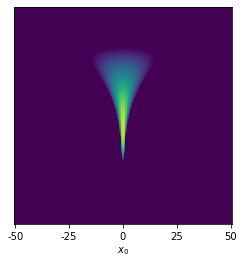

In [4]:
from scipy.stats import norm
fig, ax = plt.subplots()
r = 100
# x, v = np.meshgrid(np.linspace(-20, 20, r), np.linspace(-9, 9, r))
x, v = np.meshgrid(np.linspace(-50, 50, r), np.linspace(-9, 9, r))
logp = norm.logpdf(v, 0, 3) + norm.logpdf(x, 0, np.exp(v / 2))
ax.imshow(logp, vmin=-7.5, vmax=-2.5, cmap="viridis", origin="lower")
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_xticks(np.linspace(0, r-1, 5))
ax.set_xticklabels(np.linspace(x.min(), x.max(), 5).astype(int))
ax.set_xlabel("$x_0$")

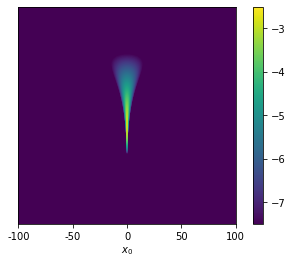

In [5]:
fig, ax = plt.subplots()
r = 1000
x, v = np.meshgrid(np.linspace(-20, 20, r).astype(float32), np.linspace(-9, 9, r).astype(float32))
x, v = np.meshgrid(np.linspace(-100, 100, r).astype(float32), np.linspace(-10, 10, r).astype(float32))
xx = np.stack([v.flatten(), x.flatten()]).T
logp2 = log_prob(xx).numpy()
im = ax.imshow(logp2.reshape(r, r), vmin=-7.5, vmax=-2.5, cmap="viridis", origin="lower")
plt.colorbar(im)
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_xticks(np.linspace(0, r-1, 5))
ax.set_xticklabels(np.linspace(x.min(), x.max(), 5).astype(int))
ax.set_xlabel("$x_0$")

xtrue, ytrue, ptrue = v, x, logp2.reshape(r, r)

<ipython-input-6-cf5c4b1a6d8b>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = plt.pcolormesh(xtrue, ytrue, np.exp(ptrue), cmap="viridis", vmin=0, vmax=0.01)


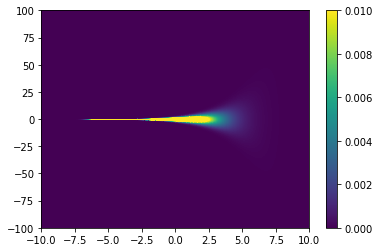

In [6]:
# plt.contourf(v, x, logp2.reshape(r, r), 20, vmin=-7.5, vmax=-2.5, cmap="viridis", origin="lower")
# plt.pcolormesh(xtrue, ytrue, ptrue , vmin=-7.5, vmax=-2.5, cmap="viridis")
im = plt.pcolormesh(xtrue, ytrue, np.exp(ptrue), cmap="viridis", vmin=0, vmax=0.01)
plt.colorbar(im)

In [7]:
nchains = 20
ndim = 1
# initstate = tf.reshape(tf.ones(2*ii), (ii,-1)) #[1., 1., 1., 1.],
# initstate = [tf.random.uniform([nchains], -1., 1. ), tf.random.uniform([nchains], -1., 1. )] #[1., 1., 1., 1.],
# initstate = tf.random.uniform([nchains, ndim+1], -3., 3. )
initstate = tf.random.uniform([nchains, ndim+1], -1., 1. )
initstate;

In [8]:
# # Initialize the HMC transition kernel.
# num_results = int(10e3)
# num_burnin_steps = int(1e3)
# adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
#     tfp.mcmc.HamiltonianMonteCarlo(
#         target_log_prob_fn=log_prob,
#         num_leapfrog_steps=30,
#         step_size=1.),
#     num_adaptation_steps=int(num_burnin_steps * 0.8))

# # Run the chain (with burn-in).
# @tf.function
# def run_chain():
#     # Run the chain (with burn-in).
#     samples, is_accepted = tfp.mcmc.sample_chain(
#       num_results=num_results,
#       num_burnin_steps=num_burnin_steps,
#       current_state= initstate,
#       kernel=adaptive_hmc,
# #         trace_fn=lambda _, pkr: pkr.inner_results.is_accepted, 
#         trace_fn=lambda _, pkr: [pkr.inner_results.is_accepted,
#                                  pkr.inner_results.accepted_results.step_size,
#                              pkr.inner_results.log_accept_ratio],
#         parallel_iterations=20)

#     return samples, is_accepted


In [9]:
# Initialize the HMC transition kernel.
num_results = int(10e3)
num_burnin_steps = int(1e3)
hmc = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=log_prob,
        num_leapfrog_steps=30,
        step_size=0.1)

# Run the chain (with burn-in).
@tf.function
def run_chain():
    # Run the chain (with burn-in).
    samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state= initstate,
      kernel=hmc,
#         trace_fn=lambda _, pkr: pkr.inner_results.is_accepted, 
        trace_fn=lambda _, pkr: [pkr.is_accepted,
                                 pkr.accepted_results.step_size,
                             pkr.log_accept_ratio],
        parallel_iterations=20)

    return samples, is_accepted


In [10]:
start = time.time()
samples, is_accepted = run_chain()
print(time.time()-start)

tfsamples = samples.numpy()

17.48262882232666


In [11]:
np.sum(is_accepted[0])/is_accepted[0].numpy().size


0.962125

In [12]:
print('step size : ', np.unique(is_accepted[1].numpy()))
is_accepted[2]
p_accept = tf.math.exp(tfp.math.reduce_logmeanexp(
    tf.minimum(is_accepted[2], 0.)))
p_accept

AttributeError: 'list' object has no attribute 'numpy'

<ipython-input-421-594443c7e57a>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[2].pcolormesh(xtrue, ytrue, (ptrue), cmap="viridis", vmin=-7, vmax=-2)


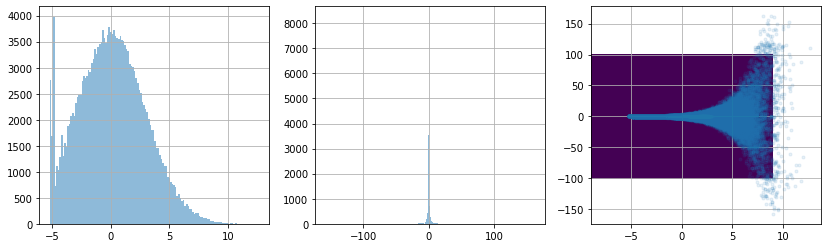

In [421]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
ax[0].hist(tfsamples[...,0].flatten(), bins='auto', alpha=0.5)
ax[1].hist(tfsamples[...,1].flatten(), bins='auto', alpha=0.5)
# ax[2].pcolormesh(xtrue, ytrue, np.exp(ptrue) , vmin=0, vmax=0.1, cmap="viridis")
ax[2].pcolormesh(xtrue, ytrue, (ptrue), cmap="viridis", vmin=-7, vmax=-2)
ax[2].plot(tfsamples[...,0].flatten(), tfsamples[...,1].flatten(),'.', alpha=0.1)
for axis in ax: axis.grid(which='both')

<ipython-input-317-2076f4e765d8>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xtrue, ytrue, (ptrue), cmap="viridis", vmin=-7, vmax=-2)


(-20.0, 20.0)

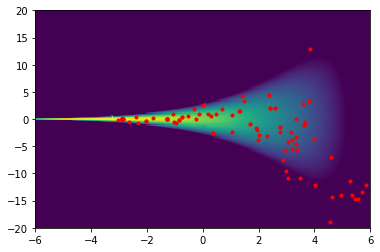

In [317]:
plt.plot(*tfsamples[:100, 0].T, 'r.')
# plt.pcolormesh(xtrue, ytrue, np.exp(ptrue), cmap="hot", vmin=0, vmax=0.01)
plt.pcolormesh(xtrue, ytrue, (ptrue), cmap="viridis", vmin=-7, vmax=-2)
plt.xlim(-6, 6)
plt.ylim(-20, 20)

IndexError: index 2 is out of bounds for axis 2 with size 2

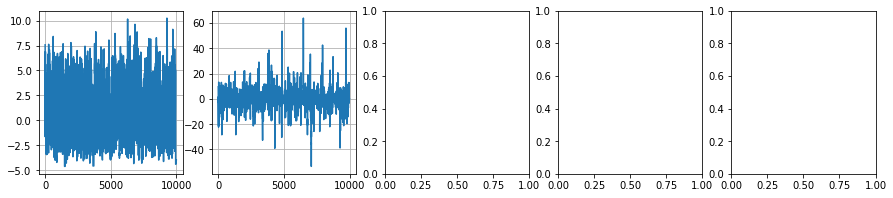

In [234]:
fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for i in range(len(ax)):
    ax[i].plot(tfsamples[:, 0, i])
    ax[i].grid()

IndexError: index 2 is out of bounds for axis 2 with size 2

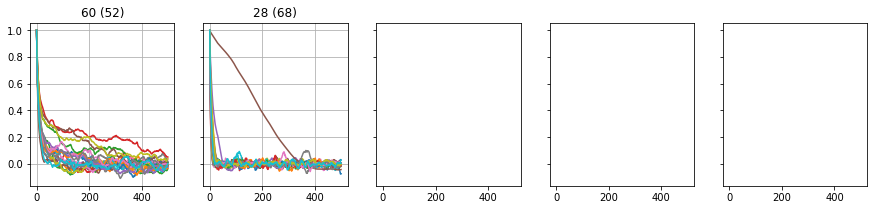

In [235]:
fig, ax = plt.subplots(1, 5, figsize=(15, 3), sharex=True, sharey=True)
for i in range(len(ax)):
    x = tfsamples[...,i]
    xp = (x - x.mean(axis=0))/x.std(axis=0)
    rcc = np.array([np.correlate(xp[:, i], xp[:, i], mode='full') for i in range(xp.shape[1])])
    rcc = rcc[:, rcc.shape[1]//2:].T
    rcc /= rcc[0]
    ax[i].plot(rcc[:500])
    ax[i].grid()
    #
    tcc = []
    for j in range(x.shape[1]):
        for m in range(500):
            if m > 5*(1 + 2*rcc[:m, j].sum()): break
        tcc.append((1 + 2*rcc[:m, j].sum()))
    tcc = np.array(tcc)
    ax[i].set_title('%d (%d)'%(tcc.mean(), tcc.std()))

# MY HMC

In [236]:
@tf.function
def leapfrog2(N, q, p, step_size, V, K):
    for i in range(N):
        phalf = p - 0.5*step_size * get_grads(V, q)[1]
        q = q + step_size * get_grads(K, phalf)[1]
        p = phalf - 0.5*step_size * get_grads(V, q)[1]
    return q, p


In [42]:
# def unnormalized_log_prob2(q):
#     x, y = q[0], q[1]
#     return  -y**2 / 9. -x **2/(tf.exp(y))**2
# def unnormalized_log_prob(x):
#     return -x - x**2.

V = lambda x: -1* log_prob(x)

@tf.function
def KE(p):
    print(p.shape)
    return 0.5 * tf.reduce_sum(p**2)


@tf.function
def H(q,p):
    return V(q) + KE(p)

@tf.function
def get_grads(f, x):
    with tf.GradientTape() as tape:
        tape.watch(x)
        fv = f(x)
    grad = tape.gradient(fv, x)
    return fv, grad
    

@tf.function
def leapfrog(N, q, p, step_size, V, K):
    p = p - 0.5*step_size * get_grads(V, q)[1]
    for i in range(N-1):
        q = q + step_size * get_grads(K, p)[1]
        p = p - step_size * get_grads(V, q)[1]
    q = q + step_size * get_grads(K, p)[1]
    p = p - 0.5*step_size * get_grads(V, q)[1]
    return q, p

@tf.function
def leapfrog_steps(N, q, p, step_size, V, K):
    toret = []
    for i in range(N):
        g0 = get_grads(V, q)
        phalf = p - 0.5*step_size * g0[1]
        q1 = q + step_size * get_grads(K, phalf)[1]
        g1 = get_grads(V, q1)
        p1 = phalf - 0.5*step_size * g1[1]
        toret.append([[q, q1], [p, phalf,p1], [g0, g1]])
        p = p1
        q = q1
    return q, p, toret


@tf.function
def metropolis(qp0, qp1, H):
    q0, p0 = qp0
    q1, p1 = qp1
    H0 = H(q0, p0)
    H1 = H(q1, p1)
    prob = tf.minimum(1., tf.exp(H0 - H1))
    if tf.math.is_nan(prob): 
        return q0, p0, 2.
    if tf.random.uniform([1], maxval=1.) > prob:
        return q0, p0, 0.
    else: return q1, p1, 1.
        
    


In [257]:
step_size = 0.05
Nleapfrog = 10 
nsamples, burnin = 1000, 1000
mysamples = []
myis_accepted = []
q = tf.constant([1., 1.])
# q = tf.constant([1.])
p = tf.random.normal(shape=q.shape)
V(q), KE(p), H(q, p);
nparallel = 10
nchains = 20



(2,)
(2,)


In [261]:
samples = tf.TensorArray(dtype=tf.float32, size=nsamples)
i = tf.constant(0)


# @tf.function
# def step(q):
#     q = tf.map_fn(hmc_step, q, parallel_iterations=nparallel)
#     return q

@tf.function
def hmc_step(q, step_size=step_size):
    p = tf.random.normal(shape=q.shape)
    q1, p1 = leapfrog(Nleapfrog, q, p, step_size, V, KE)
    q, p, accepted = metropolis([q, p], [q1, p1], H)
    return q


def hmc_body(i, q, samples):
    q = tf.map_fn(hmc_step, q, parallel_iterations=nparallel)
    samples = samples.write(i, q)
    return i+1, q, samples

def cond(i, q, samples):
    return tf.less(i, tf.constant(nsamples))

start = time.time()
i, q, mysamples = tf.while_loop(cond, hmc_body, [i, initstate, samples], parallel_iterations=nparallel)
end = time.time()
print(end - start)
mysamples = mysamples.stack().numpy()

11.198738813400269


In [262]:
mysamples.shape

(1000, 20, 2)

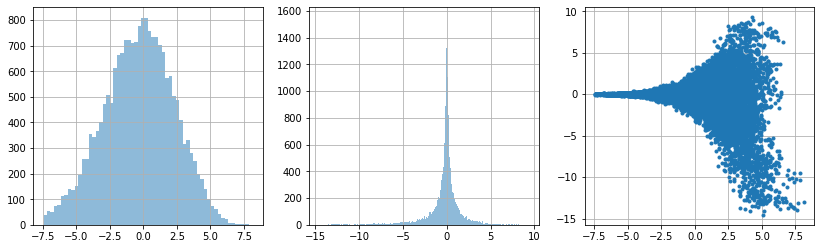

In [263]:
ii = 1
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
ax[0].hist(mysamples[...,0].flatten(), bins='auto', alpha=0.5)
ax[1].hist(mysamples[...,ii].flatten(), bins='auto', alpha=0.5)
ax[2].plot(mysamples[...,0].flatten(), mysamples[...,1].flatten(),'.')
for axis in ax: axis.grid(which='both')

In [268]:
nplot = min(ndim+1, 5)
print(nplot)
for i in range(nplot):
    print(mysamples[...,i].flatten().mean())

2
-0.3383439
-0.32545218


In [422]:
mysamples.shape

(1000, 20, 2)

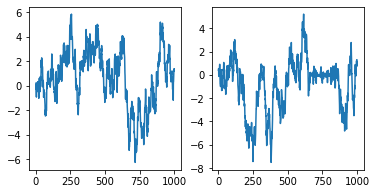

In [269]:
fig, ax = plt.subplots(1, nplot, figsize=(3*nplot, 3))
for i in range(len(ax)):
    ax[i].plot(mysamples[:, 0, i])


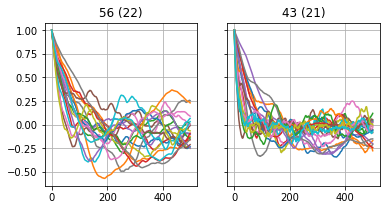

In [270]:
fig, ax = plt.subplots(1, nplot, figsize=(3*nplot, 3), sharex=True, sharey=True)
for i in range(len(ax)):
    x = mysamples[...,i]
    xp = (x - x.mean(axis=0))/x.std(axis=0)
    rcc = np.array([np.correlate(xp[:, i], xp[:, i], mode='full') for i in range(xp.shape[1])])
    rcc = rcc[:, rcc.shape[1]//2:].T
    rcc /= rcc[0]
    ax[i].plot(rcc[:500])
    ax[i].grid()
    #
    tcc = []
    for j in range(x.shape[1]):
        for m in range(500):
            if m > 5*(1 + 2*rcc[:m, j].sum()): break
        tcc.append((1 + 2*rcc[:m, j].sum()))
    tcc = np.array(tcc)
    ax[i].set_title('%d (%d)'%(tcc.mean(), tcc.std()))

# Loaded runs

In [126]:
path = '../scripts/outputs/Ndim10/step005_nleap100/'
# path = '/Users/cmodi/Research/Projects/hmc/scripts/tfoutputs/outputs5/Ndim10/step005_nleap100/'

In [129]:
samples = np.load(path + 'samples.npy')
acc = np.load(path + 'accepted.npy')
probs = np.load(path + 'probs.npy')

In [9]:
probs[..., 0], probs[..., 1];

NameError: name 'probs' is not defined

In [131]:
np.exp(probs[..., 0]-probs[..., 1]), acc

(array([[0.99133851, 0.96831885, 0.98338787, ..., 1.00001555, 1.00154221,
         1.00177246],
        [1.00158176, 1.07523144, 0.99379435, ..., 1.00006746, 1.00163603,
         1.00122376],
        [1.00302097, 0.96843338, 1.03621866, ..., 0.99585729, 1.03595466,
         0.99768003],
        ...,
        [1.0006839 , 0.99308145, 1.00164052, ..., 0.99812857, 1.0015544 ,
         0.98950531],
        [0.9994929 , 0.96842667, 1.0069829 , ..., 0.99822945, 0.99795243,
         1.00347944],
        [0.99987489, 1.05472946, 0.96702997, ..., 1.00215074, 0.9971412 ,
         1.00404319]]),
 array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]))

(array([ 2288.,  6966., 14492., 20322., 21917., 17204., 10190.,  4682.,
         1795.,   144.]),
 array([-7.14140641, -5.46637948, -3.79135255, -2.11632562, -0.44129869,
         1.23372824,  2.90875517,  4.5837821 ,  6.25880903,  7.93383596,
         9.60886289]),
 <BarContainer object of 10 artists>)

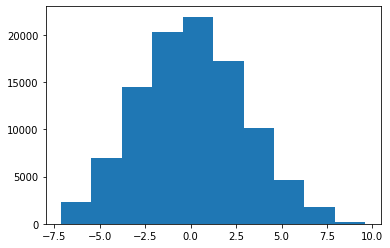

In [132]:
plt.hist(samples[..., 0].flatten())

In [16]:
ndim = 5
Lpath = 5
steps = [0.2, 0.1, 0.05, 0.01]
facs = [2, 5, 10]
nsteps = len(steps)
nfacs = len(facs)
samples = {}
samplesstan = {}
acc = {}
probs = {}
for i in range(nsteps):    
    Nleapfrog = int(Lpath / steps[i])
    Nleapfrog = max(10, Nleapfrog)
    fpath = '../scripts/outputs/Ndim%02d/'%ndim
    fpath = fpath + 'step%03d_nleap%02d/'%(steps[i]*100, Nleapfrog)
    key = 'step %0.3f'%(steps[i])
    try:
        samples[key] = np.load(fpath + '/samples.npy')
        acc[key] = np.load(fpath + '/accepted.npy')
        probs[key] = np.load(fpath + '/probs.npy')
    except: pass
    fpath = '../scripts/outputs_stan//Ndim%02d/'%ndim
    fpath = fpath + 'step%03d_nleap%02d/'%(steps[i]*100, Nleapfrog)
    key = 'step %0.3f'%(steps[i])
    try:
        samplesstan[key] = np.load(fpath + '/samples.npy')
    except: pass
    for fac in facs:
        fpath = '../scripts/outputs/Ndim%02d/'%ndim
        fpath = fpath + 'step%03d_nleap%02d_fac%02d/'%(steps[i]*100, Nleapfrog, fac)
        key = 'step %0.3f//%d'%(steps[i],  fac)
        try: samples[key] = np.load(fpath + '/samples.npy')
        except: pass

In [17]:
(acc['step 0.200'] == 1).sum()/(acc['step 0.100'].size)

KeyError: 'step 0.200'

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


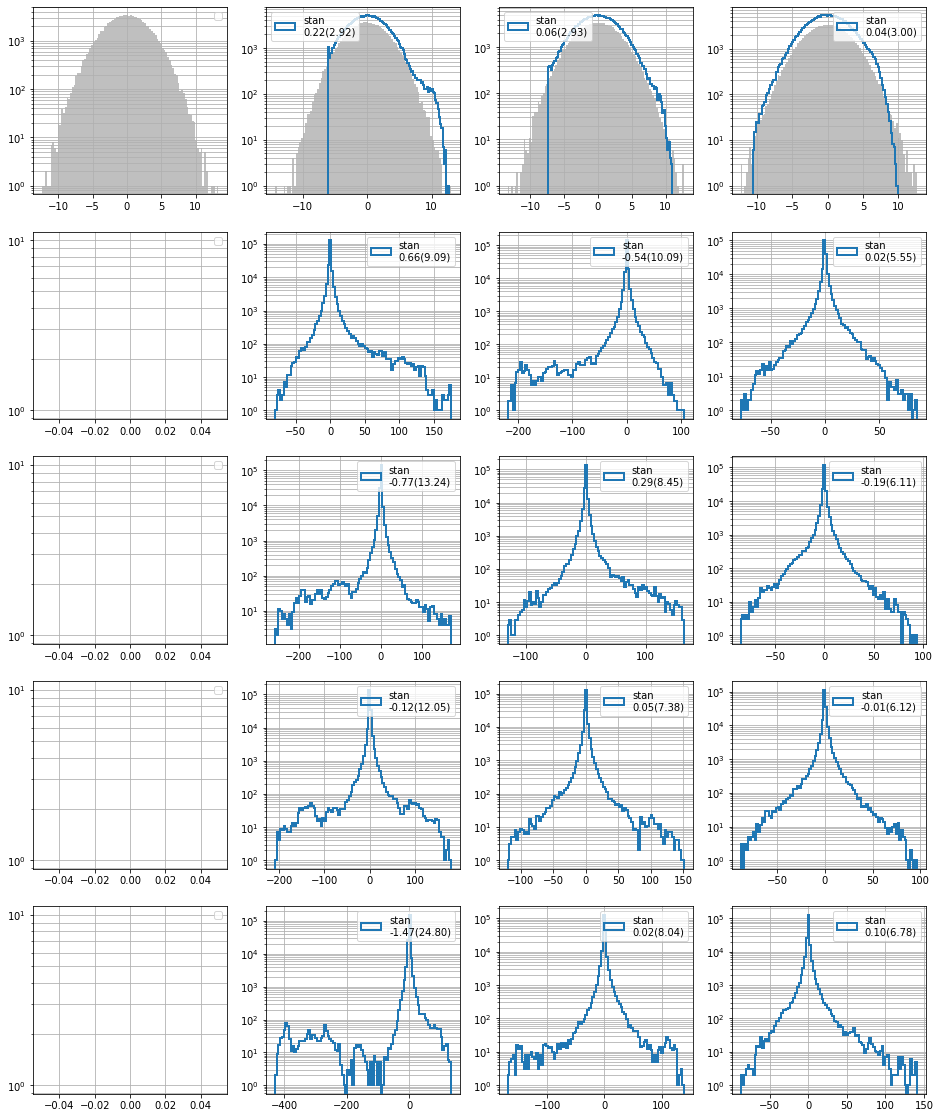

In [18]:
# bins = 'auto'
bins = 100

nplot = min(5, ndim)
fig, axar = plt.subplots(nplot, nsteps, figsize=(nsteps*4, 4*nplot))
for d in range(nplot):
    ax = axar[d]
    for i, ss in enumerate(steps):
        try: 
            mu, sig = samples['step %0.3f'%ss][...,d].flatten().mean(), samples['step %0.3f'%ss][...,d].flatten().std()
            lbl = '%0.3f\n%0.2f(%0.2f)'%(steps[i], mu, sig)
            ax[i].hist(samples['step %0.3f'%ss][...,d].flatten(), bins=bins, 
                 alpha=1, label=lbl, histtype='step', lw=2)
        except: pass
        try: 
            mu, sig = samplesstan['step %0.3f'%ss][...,d].flatten().mean(), samplesstan['step %0.3f'%ss][...,d].flatten().std()
            lbl = 'stan\n%0.2f(%0.2f)'%(mu, sig)
            ax[i].hist(samplesstan['step %0.3f'%ss][...,d].flatten(), bins=bins, 
                 alpha=1, label=lbl, histtype='step', lw=2)
        except: pass
        for j, ff in enumerate(facs):
            try:
                key = 'step %0.3f//%d'%(ss, ff)
                mu, sig = samples[key][...,d].flatten().mean(), samples[key][...,d].flatten().std()
                lbl = '//%d\n%0.2f(%0.2f)'%(ff, mu, sig)
                ax[i].hist(samples[key][...,d].flatten(), bins=bins, 
                 alpha=1, label=lbl, histtype='step', lw=2)
            except: pass

for axis in axar[0]:
    axis.hist(np.random.normal(0, 3, 100000), alpha=0.5, bins=bins, color='gray')
for axis in axar.flatten():
    axis.grid(which='both')
    axis.semilogy()
    axis.legend()
plt.show()


# fig, axar = plt.subplots(nplot, nsteps, figsize=(nsteps*4, 4*nplot))

# for d in range(nplot):
#     for i, ss in enumerate(steps):
#         ax[i].hist(samples['step %0.3f'%ss][...,0].flatten(), bins=bins, 
#                  alpha=1, label='%0.3f'%steps[i], histtype='step', lw=2)
#         for j, ff in enumerate(facs):
#             try: ax[i].hist(samples['step %0.3f//%d'%(ss, ff)][...,0].flatten(), bins=bins, 
#                  alpha=1, label='%0.3f//%d'%(ss, ff), histtype='step', lw=2)
#             except: pass
        
# for axis in ax:
#     axis.hist(np.random.normal(0, 3, 100000), alpha=0.5, bins=bins, color='gray')
#     axis.grid(which='both')
#     axis.semilogy()
#     axis.legend()
# plt.show()

In [147]:
ii = 2
iss = 0
plt.scatter(samples[iss][..., 0].flatten(), samples[iss][...,ii].flatten(), marker='.')
plt.grid(which='both')

KeyError: 0

# ultisub

In [200]:
ndim = 5
Lpath = 5
steps = [0.2, 0.1, 0.05, 0.01]
facs = [2, 5, 10]
nsteps = len(steps)
nfacs = len(facs)
samples0 = {}
samplesstan = {}
acc = {}
probs = {}
for i in range(nsteps):    
    Nleapfrog = int(Lpath / steps[i])
    Nleapfrog = max(10, Nleapfrog)
    fpath = '../scripts/outputs/Ndim%02d/'%ndim
    fpath = fpath + 'step%03d_nleap%02d/'%(steps[i]*100, Nleapfrog)
    key = 'step %0.3f'%(steps[i])
    try:
        samples0[key] = np.load(fpath + '/samples.npy')
        acc[key] = np.load(fpath + '/accepted.npy')
        probs[key] = np.load(fpath + '/probs.npy')
    except Exception as e: print(e)
    fpath = '../scripts/outputs_stan//Ndim%02d/'%ndim
    fpath = fpath + 'step%03d_nleap%02d/'%(steps[i]*100, Nleapfrog)
    key = 'step %0.3f'%(steps[i])
    try:
        samplesstan[key] = np.load(fpath + '/samples.npy')
    except: pass
    for fac in facs:
        fpath = '../scripts/outputs/Ndim%02d/'%ndim
        fpath = fpath + 'step%03d_nleap%02d_fac%02d/'%(steps[i]*100, Nleapfrog, fac)
        key = 'step %0.3f//%d'%(steps[i],  fac)
        try: samples0[key] = np.load(fpath + '/samples.npy')
        except: pass

In [201]:
samples0.keys()

dict_keys(['step 0.200', 'step 0.200//2', 'step 0.200//5', 'step 0.200//10', 'step 0.100', 'step 0.100//2', 'step 0.100//5', 'step 0.100//10', 'step 0.050', 'step 0.050//2', 'step 0.050//5', 'step 0.050//10', 'step 0.010', 'step 0.010//2', 'step 0.010//5', 'step 0.010//10'])

In [236]:
# ndim = 5
steps = [1.0, 0.5, 0.2, 0.1]
facs = [2, 5]
subs = [2, 3, 4, 5, 6]
nsteps = len(steps)
nfacs = len(facs)
samples = {}
samplesstan = {}
acc = {}
probs = {}
for i in range(nsteps):    
    Nleapfrog = int(Lpath / steps[i])
#     Nleapfrog = max(10, Nleapfrog)
    fpath = '../scripts/outputs_ccm//Ndim%02d/'%ndim
    fpath = fpath + 'step%03d_nleap%02d/'%(steps[i]*100, Nleapfrog)
    key = 'step %0.3f'%(steps[i])
    try:
        samples[key] = np.load(fpath + '/samples.npy')
        acc[key] = np.load(fpath + '/accepted.npy')
        probs[key] = np.load(fpath + '/probs.npy')
    except: pass
    fpath = '../scripts/outputs_stan//Ndim%02d/'%ndim
    fpath = fpath + 'step%03d_nleap%02d/'%(steps[i]*100, Nleapfrog)
    key = 'step %0.3f'%(steps[i])
    try:
        samplesstan[key] = np.load(fpath + '/samples.npy')
    except: pass
    for fac in facs:
#         fpath = '../scripts/outputs/Ndim%02d/'%ndim
#         fpath = fpath + 'step%03d_nleap%02d_fac%02d/'%(steps[i]*100, Nleapfrog, fac)
#         key = 'step %0.3f//%d'%(steps[i],  fac)
#         try: samples[key] = np.load(fpath + '/samples.npy')
#         except: pass
        for sub in subs:
            fpath = '../scripts/outputs_ccm/Ndim%02d/'%ndim
            fpath = fpath + 'step%03d_nleap%02d_fac%02d_nsub%d/'%(steps[i]*100, Nleapfrog, fac, sub)
            key = 'step %0.3f//%d-%d'%(steps[i],  fac, sub)
            try: 
                samples[key] = np.load(fpath + '/samples.npy')
                acc[key] = np.load(fpath + '/accepted.npy')
            except Exception as e: print(e)

[Errno 2] No such file or directory: '../scripts/outputs_ccm/Ndim05/step100_nleap05_fac05_nsub5//samples.npy'
[Errno 2] No such file or directory: '../scripts/outputs_ccm/Ndim05/step100_nleap05_fac05_nsub6//samples.npy'
[Errno 2] No such file or directory: '../scripts/outputs_ccm/Ndim05/step050_nleap10_fac05_nsub5//samples.npy'
[Errno 2] No such file or directory: '../scripts/outputs_ccm/Ndim05/step050_nleap10_fac05_nsub6//samples.npy'
[Errno 2] No such file or directory: '../scripts/outputs_ccm/Ndim05/step020_nleap25_fac05_nsub5//samples.npy'
[Errno 2] No such file or directory: '../scripts/outputs_ccm/Ndim05/step020_nleap25_fac05_nsub6//samples.npy'
[Errno 2] No such file or directory: '../scripts/outputs_ccm/Ndim05/step010_nleap50_fac05_nsub2//samples.npy'
[Errno 2] No such file or directory: '../scripts/outputs_ccm/Ndim05/step010_nleap50_fac05_nsub3//samples.npy'
[Errno 2] No such file or directory: '../scripts/outputs_ccm/Ndim05/step010_nleap50_fac05_nsub4//samples.npy'
[Errno 2] 

In [210]:
samples.keys()

dict_keys(['step 1.000', 'step 1.000//2-2', 'step 1.000//2-3', 'step 1.000//2-4', 'step 1.000//2-5', 'step 1.000//2-6', 'step 1.000//5-2', 'step 1.000//5-3', 'step 1.000//5-4', 'step 0.500', 'step 0.500//2-2', 'step 0.500//2-3', 'step 0.500//2-4', 'step 0.500//2-5', 'step 0.500//2-6', 'step 0.500//5-2', 'step 0.500//5-3', 'step 0.500//5-4', 'step 0.200', 'step 0.200//2-2', 'step 0.200//2-3', 'step 0.200//2-4', 'step 0.200//2-5', 'step 0.200//2-6', 'step 0.200//5-2', 'step 0.200//5-3', 'step 0.200//5-4', 'step 0.100', 'step 0.100//2-2', 'step 0.100//2-3', 'step 0.100//2-4', 'step 0.100//2-5', 'step 0.100//2-6'])

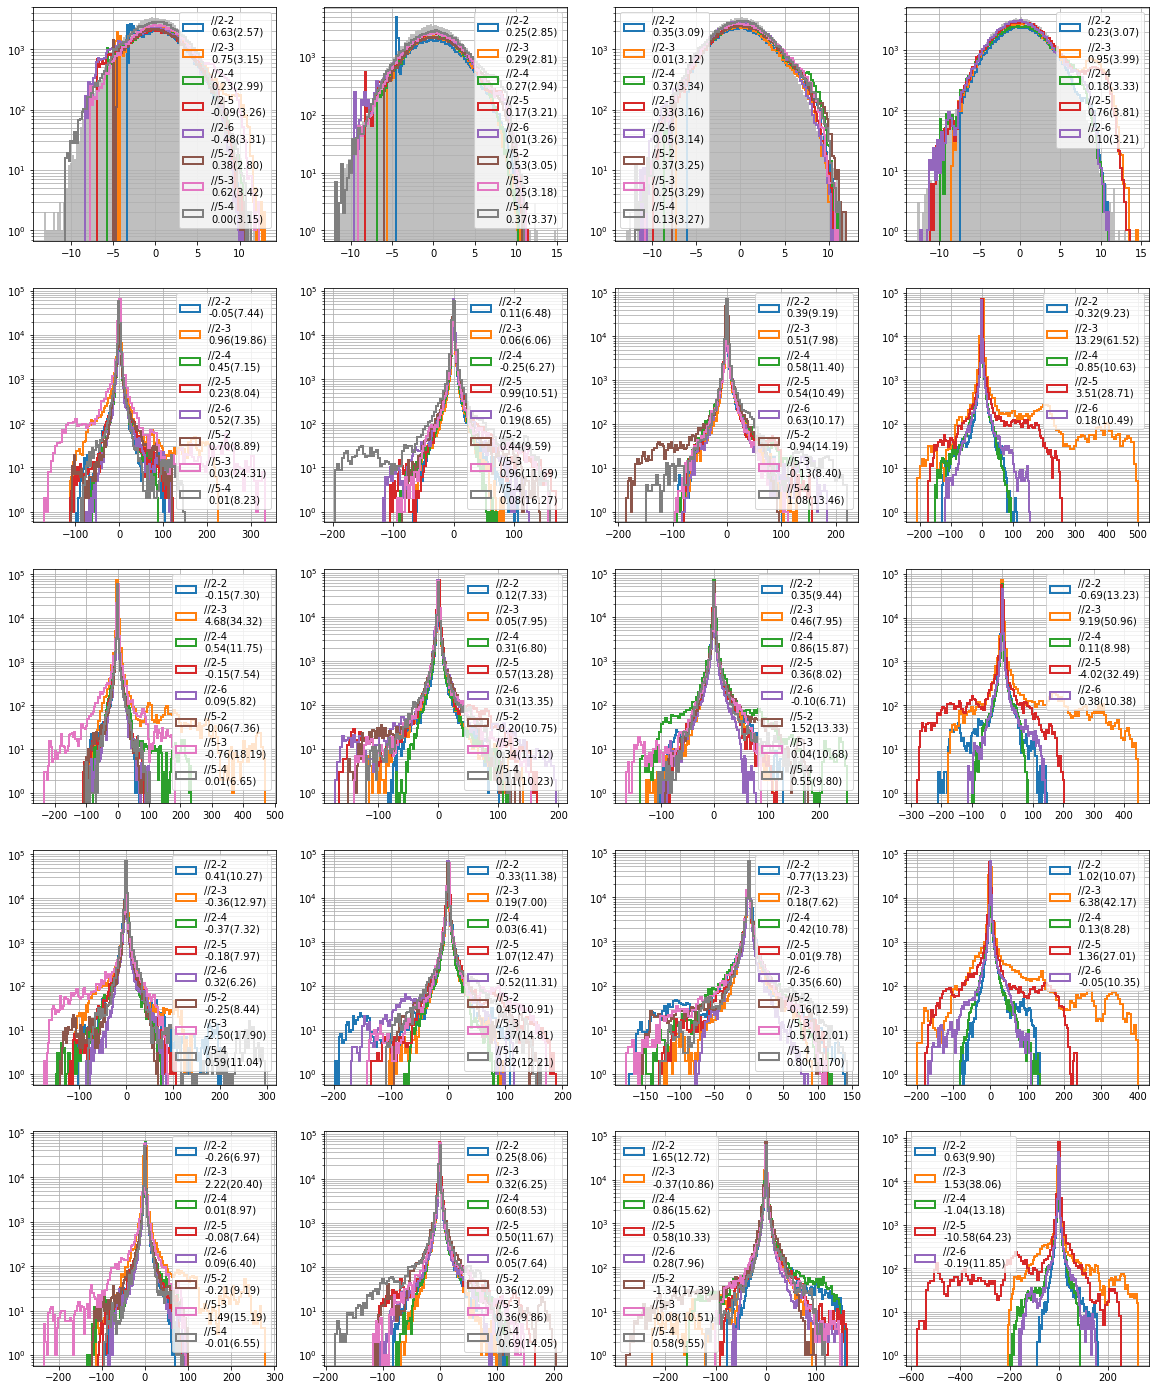

In [211]:
# bins = 'auto'
bins = 100

nplot = min(5, ndim)
fig, axar = plt.subplots(nplot, nsteps, figsize=(nsteps*5, 5*nplot))
for d in range(nplot):
    ax = axar[d]
    for i, ss in enumerate(steps):
        try: 
            mu, sig = samples['step %0.3f'%ss][...,d].flatten().mean(), samples['step %0.3f'%ss][...,d].flatten().std()
            lbl = '%0.3f\n%0.2f(%0.2f)'%(steps[i], mu, sig)
#             ax[i].hist(samples['step %0.3f'%ss][...,d].flatten(), bins=bins, 
#                  alpha=1, label=lbl, histtype='step', lw=2)
        except: pass
#         try: 
#             mu, sig = samplesstan['step %0.3f'%ss][...,d].flatten().mean(), samplesstan['step %0.3f'%ss][...,d].flatten().std()
#             lbl = 'stan\n%0.2f(%0.2f)'%(mu, sig)
#             ax[i].hist(samplesstan['step %0.3f'%ss][...,d].flatten(), bins=bins, 
#                  alpha=1, label=lbl, histtype='step', lw=2)
#         except: pass
        for j, ff in enumerate(facs):
            for k, sub in enumerate(subs):
                try:
                    key = 'step %0.3f//%d-%d'%(ss, ff, sub)
                    mu, sig = samples[key][...,d].flatten().mean(), samples[key][...,d].flatten().std()
                    lbl = '//%d-%d\n%0.2f(%0.2f)'%(ff,sub,  mu, sig)
                    ax[i].hist(samples[key][...,d].flatten(), bins=bins, 
                     alpha=1, label=lbl, histtype='step', lw=2)
                except: pass

for axis in axar[0]:
    axis.hist(np.random.normal(0, 3, 100000), alpha=0.5, bins=bins, color='gray')
for axis in axar.flatten():
    axis.grid(which='both')
    axis.semilogy()
    axis.legend()
plt.show()


# fig, axar = plt.subplots(nplot, nsteps, figsize=(nsteps*4, 4*nplot))

# for d in range(nplot):
#     for i, ss in enumerate(steps):
#         ax[i].hist(samples['step %0.3f'%ss][...,0].flatten(), bins=bins, 
#                  alpha=1, label='%0.3f'%steps[i], histtype='step', lw=2)
#         for j, ff in enumerate(facs):
#             try: ax[i].hist(samples['step %0.3f//%d'%(ss, ff)][...,0].flatten(), bins=bins, 
#                  alpha=1, label='%0.3f//%d'%(ss, ff), histtype='step', lw=2)
#             except: pass
        
# for axis in ax:
#     axis.hist(np.random.normal(0, 3, 100000), alpha=0.5, bins=bins, color='gray')
#     axis.grid(which='both')
#     axis.semilogy()
#     axis.legend()
# plt.show()

# rank plots

In [170]:
sigmarep = np.random.normal(0,3,1000000)
yvrep = np.random.normal(0,1,1000000)
alpharep = np.exp(sigmarep/2.)*yvrep
# hh = plt.hist2d(sigmarep, alpharep, bins=100, density=True)[0]

In [73]:
def get_rcc(x):
    xp = (x - x.mean(axis=0))/x.std(axis=0)
    rcc = np.array([np.correlate(xp[:, i], xp[:, i], mode='full') for i in range(xp.shape[1])])
    rcc = rcc[:, rcc.shape[1]//2:].T
    rcc /= rcc[0]
    tcc = []
    for j in range(x.shape[1]):
        for m in range(1000):
            if m > 5*(1 + 2*rcc[:m, j].sum()): break
        tcc.append((1 + 2*rcc[:m, j].sum()))
    tcc = np.array(tcc)
    return rcc, tcc




In [74]:
# test = samples['step 0.100//2-5']
test = samples['step 0.100//2-3']
test0 = samples0['step 0.050']
ii = 0
rcc, tcc = get_rcc(test[..., ii])
rcc0, tcc0 = get_rcc(test0[..., ii])
print(tcc.mean(), tcc0.mean())
# hmcsamples = (test[:, :, 0].flatten())
# hmcsamples = (test[::int(tcc.mean()), :, 0].flatten())
hmcsamples = (np.concatenate([test[::int(tcc[i]), i, ii] for i in range(test.shape[1])]))
hmcsamples0 = (np.concatenate([test0[::int(tcc0[i]), i, ii] for i in range(test0.shape[1])]))


33.96951378734616 17.860420554165632


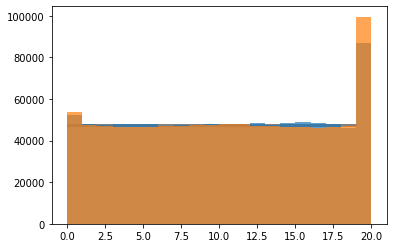

In [75]:
nbins = 20
batch = hmcsamples[np.random.randint(0, hmcsamples.size, nbins*sigmarep.size).reshape(nbins, sigmarep.size)] 
if ii == 0: ranks = (batch < sigmarep).sum(axis=0)
else: ranks = (batch < alpharep).sum(axis=0)

batch = hmcsamples0[np.random.randint(0, hmcsamples0.size, nbins*sigmarep.size).reshape(nbins, sigmarep.size)] 
if ii == 0: ranks0 = (batch < sigmarep).sum(axis=0)
else: ranks0 = (batch < alpharep).sum(axis=0)

q0 = np.quantile(np.random.binomial(sigmarep.size, 1/(nbins+1), 100000), 0.005)
q1 = np.quantile(np.random.binomial(sigmarep.size, 1/(nbins+1), 100000), 0.995)
# ranks = np.searchsorted(hmcsamples, sigmarep)
plt.hist(ranks, bins=nbins, alpha=0.7);
plt.hist(ranks0, bins=nbins, alpha=0.7);
plt.fill_between(np.arange(0, nbins), q0, q1, color='gray')

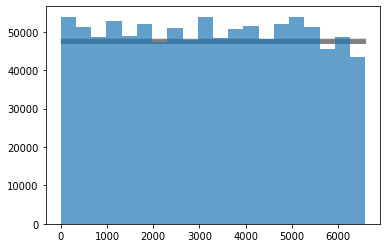

In [76]:
hmcsamples = np.sort(np.concatenate([test[::int(tcc[i]), i, ii] for i in range(test.shape[1])]))
if ii == 0: ranks = np.searchsorted(hmcsamples, sigmarep)
else: ranks = np.searchsorted(hmcsamples, alpharep)
nbins = 20

q0 = np.quantile(np.random.binomial(sigmarep.size, 1/(nbins+1), 100000), 0.005)
q1 = np.quantile(np.random.binomial(sigmarep.size, 1/(nbins+1), 100000), 0.995)
plt.hist(ranks, bins=nbins, alpha=0.7);
plt.fill_between(np.arange(0, ranks.max()), q0, q1, color='gray')

In [77]:
nbins = 20
q0 = np.quantile(np.random.binomial(sigmarep.size, 1/(nbins+1), 100000), 0.005)
q1 = np.quantile(np.random.binomial(sigmarep.size, 1/(nbins+1), 100000), 0.995)
ii = 0



In [181]:
# nbins = 20
# q0 = np.quantile(np.random.binomial(sigmarep.size, 1/(nbins+1), 100000), 0.005)
# q1 = np.quantile(np.random.binomial(sigmarep.size, 1/(nbins+1), 100000), 0.995)
# ii = 0


# fig, axar = plt.subplots(3, 4, figsize=(18, 12 ), sharex=True)

# for iff, fidkey in enumerate (['step 0.200', 'step 0.100', 'step 0.050', 'step 0.010']): 

#     ax = axar[0, iff]
#     keys = [fidkey] + [fidkey + '//%s'%i for i in [2, 5, 10]]

#     for ik, kk in enumerate(keys):
#         try: test = samples0[kk]
#         except Exception as e: 
#             print(e)
#             continue
#         rcc, tcc = get_rcc(test[..., ii])
# #         hmcsamples = (np.concatenate([test[::, i, ii] for i in range(test.shape[1])]))
# #         hmcsamples = (np.concatenate([test[::int(tcc.mean()), i, ii] for i in range(test.shape[1])]))
#         hmcsamples = (np.concatenate([test[::int(tcc[i]), i, ii] for i in range(test.shape[1])]))

#         batch = hmcsamples[np.random.randint(0, hmcsamples.size, nbins*sigmarep.size).reshape(nbins, sigmarep.size)] 
#         if ii == 0: ranks = (batch < sigmarep).sum(axis=0)
#         else: ranks = (batch < alpharep).sum(axis=0)

#         ax.hist(ranks, bins=np.arange(nbins+2)-0.5, alpha=1, label=kk, histtype='step', lw=2);
# #         ax.hist(ranks, bins=nbins, alpha=0.5, label=kk);        


# for iff, fidkey in enumerate (['step 1.000//2', 'step 0.500//2', 'step 0.200//2', 'step 0.100//2', 
#                               'step 1.000//5', 'step 0.500//5', 'step 0.200//5', 'step 0.100//5']): 

#     ax = axar[1:].flatten()[iff]
#     keys = [fidkey + '-%d'%i for i in [2, 3, 4, 5, 6]]
    
#     for ik, kk in enumerate(keys):
#         try: test = samples[kk]
#         except Exception as e:
#             print(e)
#             continue
#         rcc, tcc = get_rcc(test[..., ii])
# #         hmcsamples = (np.concatenate([test[::, i, ii] for i in range(test.shape[1])]))
# #         hmcsamples = (np.concatenate([test[::int(tcc.mean()), i, ii] for i in range(test.shape[1])]))
#         hmcsamples = (np.concatenate([test[::int(tcc[i]), i, ii] for i in range(test.shape[1])]))

#         batch = hmcsamples[np.random.randint(0, hmcsamples.size, nbins*sigmarep.size).reshape(nbins, sigmarep.size)] 
#         if ii == 0: ranks = (batch < sigmarep).sum(axis=0)
#         else: ranks = (batch < alpharep).sum(axis=0)

# #         ax.hist(ranks, bins=nbins, alpha=0.5, label=kk);
#         ax.hist(ranks, bins=np.arange(nbins+2)-0.5, alpha=1, label=kk, histtype='step', lw=2);
# #         ax.hist(ranks, bins=nbins, alpha=1, label=kk, histtype='step', lw=2);
#         ax.fill_between(np.arange(0, nbins), q0, q1, color='k')
        
# for axis in axar.flatten():
#     axis.grid()
#     axis.legend(loc='lower center')
#     axis.fill_between(np.arange(0, nbins), q0, q1, color='k', alpha=0.5)


# plt.suptitle('Rank  plots for log sigma', fontsize=14)
# plt.tight_layout()

# ECDF

1980
540
1420
680
1300
2180
1980
1420
3340
2180
2500
1620
1160
2580
2640
2400
720
440
1040
1060
1400
1000
800
1620
'step 1.000//5-5'
'step 1.000//5-6'
760
1360
1680
820
920
1140
1140
800
'step 0.500//5-5'
'step 0.500//5-6'
1220
1440
940
1380
1380
1040
1300
1180
'step 0.200//5-5'
'step 0.200//5-6'
1220
580
1100
920
1120


No handles with labels found to put in legend.


'step 0.100//5-2'
'step 0.100//5-3'
'step 0.100//5-4'
'step 0.100//5-5'
'step 0.100//5-6'
0.048634558216593585


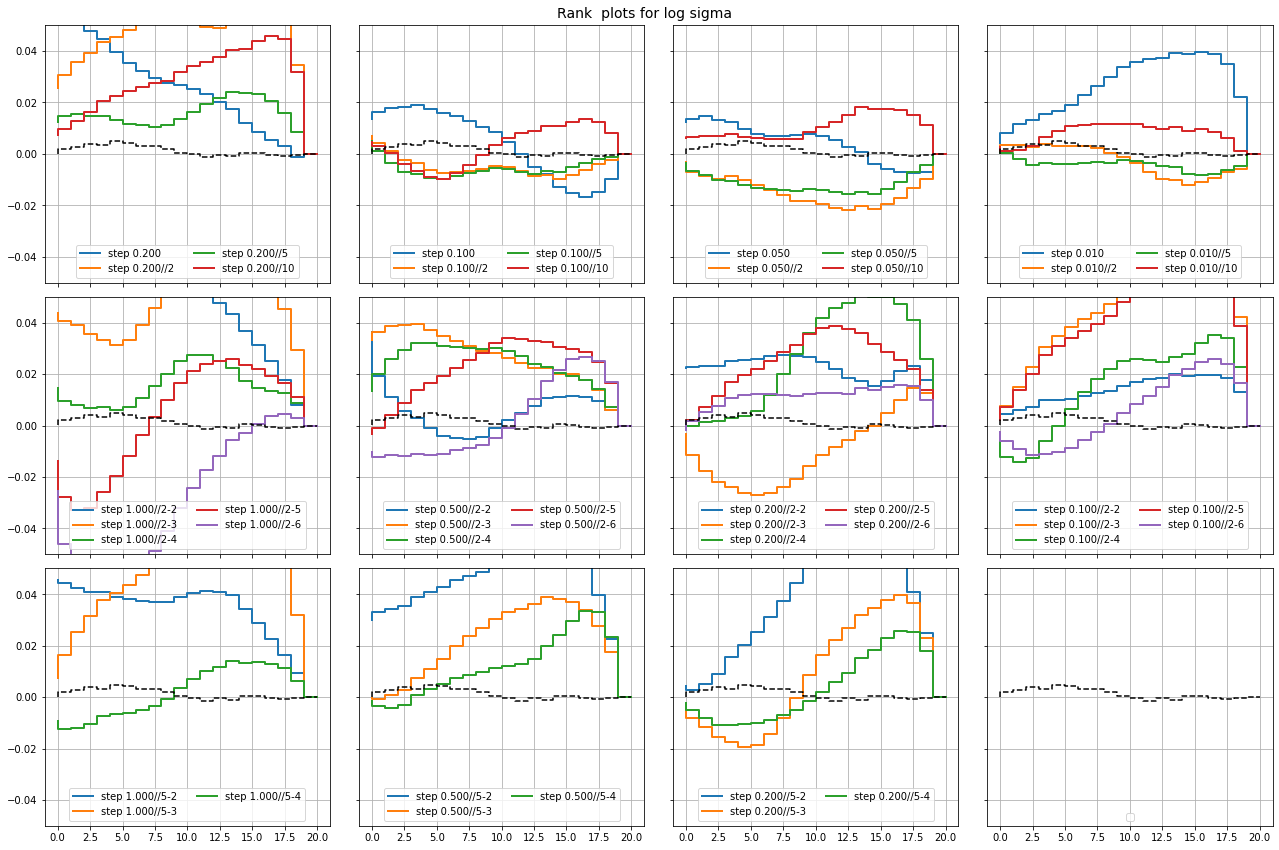

In [216]:
nbins = 20
uranks = np.random.randint(0, nbins+1, 5000*20)
cdfuranks = np.cumsum(np.unique(uranks, return_counts=True)[1])
cdfuranks = cdfuranks/cdfuranks[-1]

uranks = np.random.randint(0, nbins+1, 5000*20)
cdfuranks2 = np.cumsum(np.unique(uranks, return_counts=True)[1])
cdfuranks2 = cdfuranks2/cdfuranks2[-1]
errucdf = cdfuranks-cdfuranks2
xpts = np.arange(0, nbins+1)

q0 = np.quantile(np.random.binomial(sigmarep.size, 1/(nbins+1), 100000), 0.005)
q1 = np.quantile(np.random.binomial(sigmarep.size, 1/(nbins+1), 100000), 0.995)
ii = 0


fig, axar = plt.subplots(3, 4, figsize=(18, 12 ), sharex=True, sharey=True)


def clean_samples(test):
        rcc, tcc = get_rcc(test[..., ii])
#         hmcsamples = (np.concatenate([test[::, i, ii] for i in range(test.shape[1])]))
        hmcsamples = (np.concatenate([test[::int(tcc.mean()), i, ii] for i in range(test.shape[1])]))
#         hmcsamples = (np.concatenate([test[::int(tcc[i]), i, ii] for i in range(test.shape[1])]))
#         hmcsamples = (np.concatenate([test[::200, i, ii] for i in range(test.shape[1])]))
        return hmcsamples
    
for iff, ss in enumerate([0.2, 0.1, 0.05, 0.01]):
    fidkey = 'step %0.3f'%ss    
    ax = axar[0, iff]
    
    for ik, nsub in enumerate([0, 2, 5, 10]):
        
        if nsub == 0: kk = fidkey
        else: kk = fidkey + '//%s'%nsub
        try: test = samples0[kk]
        except Exception as e: 
            print("excpetion : ", e)
            continue

        hmcsamples = clean_samples(test)    
        print(hmcsamples.size)
        if hmcsamples.size < 200: continue
        batch = hmcsamples[np.random.randint(0, hmcsamples.size, nbins*sigmarep.size).reshape(nbins, sigmarep.size)] 
        if ii == 0: ranks = (batch < sigmarep).sum(axis=0)
        else: ranks = (batch < alpharep).sum(axis=0)

        cdfranks = np.cumsum(np.unique(ranks, return_counts=True)[1])
        cdfranks = cdfranks/cdfranks[-1]
        ax.step(xpts, cdfranks - cdfuranks, label=kk, lw=2)


# for iff, fidkey in enumerate (['step 1.000//2', 'step 0.500//2', 'step 0.200//2', 'step 0.100//2', 
#                               'step 1.000//5', 'step 0.500//5', 'step 0.200//5', 'step 0.100//5']): 
for iss, ss in enumerate([1.0, 0.5, 0.2, 0.1]):
    for ifac, fac in enumerate([2, 5]):
        
        iff = iss + 4*ifac
        fidkey = 'step %0.3f//%d'%(ss, fac)    

        ax = axar[1:].flatten()[iff]

        for insub, nsub in enumerate([2, 3, 4, 5, 6]):
            kk = fidkey + '-%d'%nsub
            try: test = samples[kk]
            except Exception as e:
                print(e)
                continue
                
            hmcsamples = clean_samples(test)    
            print(hmcsamples.size)
            if hmcsamples.size < 200: continue

            batch = hmcsamples[np.random.randint(0, hmcsamples.size, nbins*sigmarep.size).reshape(nbins, sigmarep.size)] 
            if ii == 0: ranks = (batch < sigmarep).sum(axis=0)
            else: ranks = (batch < alpharep).sum(axis=0)

            cdfranks = np.cumsum(np.unique(ranks, return_counts=True)[1])
            cdfranks = cdfranks/cdfranks[-1]
            ax.step(xpts, cdfranks - cdfuranks, label=kk, lw=2)


alpha = 0.01
nobs = hmcsamples.size
epsilon = np.sqrt(np.log(2.0 / alpha) / (2 * nobs))
print(epsilon)
for axis in axar.flatten():
    axis.grid()
    axis.legend(loc='lower center', ncol=2)
#     axis.fill_between(np.arange(0, nbins+1), -epsilon, epsilon, color='gray', alpha=0.2)
#     axis.fill_between(np.arange(0, nbins), q0, q1, color='k')
    axis.step(xpts, cdfuranks-cdfuranks2, 'k--')
    axis.set_ylim(-0.05, 0.05)
plt.suptitle('Rank  plots for log sigma', fontsize=14)
plt.tight_layout()

'step 1.000//5-5'
'step 1.000//5-6'
'step 0.500//5-5'
'step 0.500//5-6'
'step 0.200//5-5'
'step 0.200//5-6'


No handles with labels found to put in legend.


'step 0.100//5-2'
'step 0.100//5-3'
'step 0.100//5-4'
'step 0.100//5-5'
'step 0.100//5-6'
0.10973436279724899


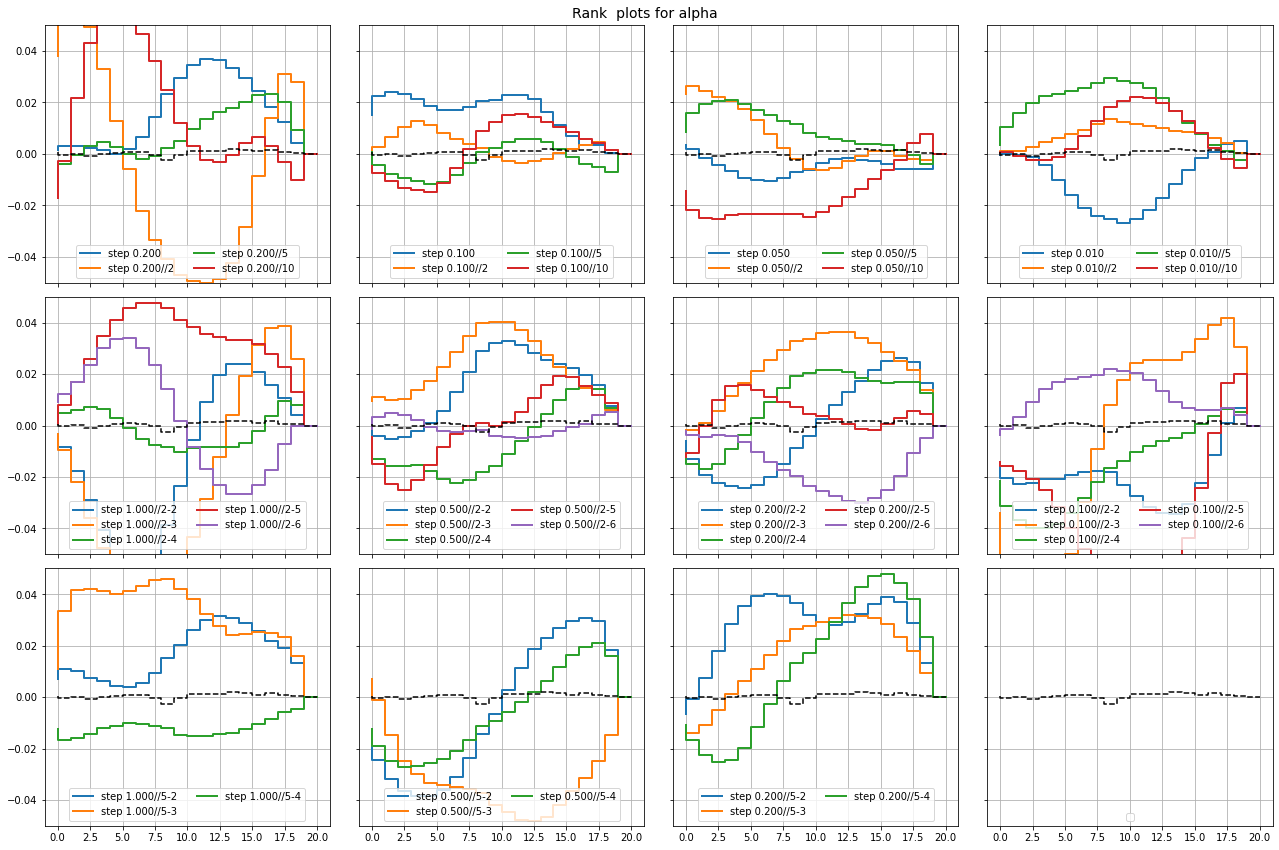

In [213]:
nbins = 20
uranks = np.random.randint(0, nbins+1, 5000*20)
cdfuranks = np.cumsum(np.unique(uranks, return_counts=True)[1])
cdfuranks = cdfuranks/cdfuranks[-1]

uranks = np.random.randint(0, nbins+1, 5000*20)
cdfuranks2 = np.cumsum(np.unique(uranks, return_counts=True)[1])
cdfuranks2 = cdfuranks2/cdfuranks2[-1]
errucdf = cdfuranks-cdfuranks2
xpts = np.arange(0, nbins+1)

q0 = np.quantile(np.random.binomial(sigmarep.size, 1/(nbins+1), 100000), 0.005)
q1 = np.quantile(np.random.binomial(sigmarep.size, 1/(nbins+1), 100000), 0.995)
ii = 1


fig, axar = plt.subplots(3, 4, figsize=(18, 12 ), sharex=True, sharey=True)

for iff, ss in enumerate([0.2, 0.1, 0.05, 0.01]):
    fidkey = 'step %0.3f'%ss    
    ax = axar[0, iff]
    
    for ik, nsub in enumerate([0, 2, 5, 10]):
        
        if nsub == 0: kk = fidkey
        else: kk = fidkey + '//%s'%nsub
        try: test = samples0[kk]
        except Exception as e: 
            print("excpetion : ", e)
            continue
        
        hmcsamples = clean_samples(test)
        batch = hmcsamples[np.random.randint(0, hmcsamples.size, nbins*sigmarep.size).reshape(nbins, sigmarep.size)] 
        if ii == 0: ranks = (batch < sigmarep).sum(axis=0)
        else: ranks = (batch < alpharep).sum(axis=0)

        cdfranks = np.cumsum(np.unique(ranks, return_counts=True)[1])
        cdfranks = cdfranks/cdfranks[-1]
        ax.step(xpts, cdfranks - cdfuranks, label=kk, lw=2)


for iss, ss in enumerate([1.0, 0.5, 0.2, 0.1]):
    for ifac, fac in enumerate([2, 5]):
        
        iff = iss + 4*ifac
        fidkey = 'step %0.3f//%d'%(ss, fac)    

        ax = axar[1:].flatten()[iff]

        for insub, nsub in enumerate([2, 3, 4, 5, 6]):
            kk = fidkey + '-%d'%nsub
            try: test = samples[kk]
            except Exception as e:
                print(e)
                continue
                
            hmcsamples = clean_samples(test)
            batch = hmcsamples[np.random.randint(0, hmcsamples.size, nbins*sigmarep.size).reshape(nbins, sigmarep.size)] 
            if ii == 0: ranks = (batch < sigmarep).sum(axis=0)
            else: ranks = (batch < alpharep).sum(axis=0)

            cdfranks = np.cumsum(np.unique(ranks, return_counts=True)[1])
            cdfranks = cdfranks/cdfranks[-1]
            ax.step(xpts, cdfranks - cdfuranks, label=kk, lw=2)


alpha = 0.01
nobs = hmcsamples.size
epsilon = np.sqrt(np.log(2.0 / alpha) / (2 * nobs))
print(epsilon)
for axis in axar.flatten():
    axis.grid()
    axis.legend(loc='lower center', ncol=2)
#     axis.fill_between(np.arange(0, nbins+1), -epsilon, epsilon, color='gray', alpha=0.2)
#     axis.fill_between(np.arange(0, nbins), q0, q1, color='k')
    axis.step(xpts, cdfuranks-cdfuranks2, 'k--')
    axis.set_ylim(-0.05, 0.05)
plt.suptitle('Rank  plots for alpha', fontsize=14)
plt.tight_layout()

In [254]:
for i in range(2, 7):
    key = 'step 0.500//2-%d'%i
    print(i, np.unique(acc[key], return_counts=True)[1]/(5000*20))
    print(np.sort([int('%d'%i) for i in get_rcc(samples[key][..., 0])[1]]))
    print(np.sort([int('%d'%i) for i in get_rcc(samples[key][..., 1])[1]]))

2 [0.25127 0.59149 0.15724]
[ 24  28  29  37  38  38  43  54  58  71  80 110 111 116 119 134 170 350
 464 569]
[  5   7   7  11  13  16  16  17  20  21  23  23  38  60  65  65  75  87
  97 126]
3 [0.16699 0.60476 0.15812 0.07013]
[ 29  34  36  38  38  43  45  45  56  61  63  64  65  67  70  87 102 139
 144 263]
[  9   9  10  11  11  13  17  17  19  22  27  30  33  45  46  46  57  90
 153 161]
4 [0.15088 0.60375 0.15216 0.06653 0.02668]
[ 26  29  33  35  36  40  40  42  43  44  47  49  50  51  62  64  93 104
 136 175]
[  9  10  13  14  14  14  14  19  24  26  26  26  27  30  31  37  50  59
 105 175]
5 [0.15587 0.58843 0.15017 0.06587 0.02878 0.01088]
[ 23  37  38  39  40  42  45  46  48  51  55  58  59  60  83  91 259 362
 468 528]
[  6   8  10  10  10  11  12  16  21  21  23  23  26  34  37  42  71  75
 265 498]
6 [0.15649 0.57339 0.15292 0.07002 0.03004 0.01237 0.00477]
[ 27  40  40  50  50  52  66  69  71  72  73  75  86  91 101 127 146 209
 282 462]
[  7   7   8  12  14  15  15  19 

In [214]:
# from scipy.interpolate import interp1d


# def _conf_set(F, alpha=0.05):
#     nobs = len(F)
#     epsilon = np.sqrt(np.log(2.0 / alpha) / (2 * nobs))
#     lower = np.clip(F - epsilon, 0, 1)
#     upper = np.clip(F + epsilon, 0, 1)
#     return lower, upper

# class StepFunction:
#     def __init__(self, x, y, ival=0.0, sorted=False, side="left"):
#         if side.lower() not in ["right", "left"]:
#             msg = "side can take the values 'right' or 'left'"
#             raise ValueError(msg)
#         self.side = side
#         _x = np.asarray(x)
#         _y = np.asarray(y)
#         if _x.shape != _y.shape:
#             msg = "x and y do not have the same shape"
#             raise ValueError(msg)
#         if len(_x.shape) != 1:
#             msg = "x and y must be 1-dimensional"
#             raise ValueError(msg)
#         self.x = np.r_[-np.inf, _x]
#         self.y = np.r_[ival, _y]
#         if not sorted:
#             asort = np.argsort(self.x)
#             self.x = np.take(self.x, asort, 0)
#             self.y = np.take(self.y, asort, 0)
#         self.n = self.x.shape[0]

#     def __call__(self, time):
#         tind = np.searchsorted(self.x, time, self.side) - 1
#         return self.y[tind]
    
    
# class ECDF(StepFunction):
#     def __init__(self, x, side="right"):
#         x = np.array(x, copy=True)
#         x.sort()
#         nobs = len(x)
#         y = np.linspace(1.0 / nobs, 1, nobs)
#         super(ECDF, self).__init__(x, y, side=side, sorted=True)



# # TODO: Make sure everything is correctly aligned and make a plotting
# # function
# from urllib.request import urlopen
# import matplotlib.pyplot as plt

# nerve_data = urlopen("http://www.statsci.org/data/general/nerve.txt")
# nerve_data = np.loadtxt(nerve_data)
# x = nerve_data / 50.0  # Was in 1/50 seconds
# # x = sigmarep
# cdf = ECDF(x)
# x.sort()
# F = cdf(x)
# plt.step(x, F, where="post")
# lower, upper = _conf_set(F)
# plt.step(x, lower, "r", where="post")
# plt.step(x, upper, "r", where="post")


# # x = np.random.uniform(0, 1, 10000)
# # cdf = ECDF(x)
# # x.sort()
# # F = cdf(x)
# # plt.step(x, F, where="post")
# # lower, upper = _conf_set(F)
# # plt.step(x, lower, "r", where="post")
# # plt.step(x, upper, "r", where="post")
# # # plt.xlim(0, 1.5)
# # # plt.ylim(0, 1.05)
# # # plt.vlines(x, 0, 0.05)
# # plt.show()

In [80]:
x = np.random.uniform(0, 1, ranks.size)
cdf = ECDF(x)
x = np.sort(x)
Fu = cdf(x)
x = np.random.uniform(0, 1, ranks.size)
cdf = ECDF(x)
x = np.sort(x)
Fu2 = cdf(x)

x = ranks
cdf = ECDF(x)
x = np.sort(x)
Fr = cdf(x)


# plt.plot(Fu-Fr, '.')
# plt.plot(Fu-Fu2, '.')

In [49]:
ii = 0 
#         hmcsamples = (np.concatenate([test[::int(tcc.mean()), i, ii] for i in range(test.shape[1])]))
hmcsamples = (np.concatenate([test[::int(tcc[i]), i, ii] for i in range(test.shape[1])]))

batch = hmcsamples[np.random.randint(0, hmcsamples.size, nbins*sigmarep.size).reshape(nbins, sigmarep.size)] 
if ii == 0: ranks = (batch <= sigmarep).sum(axis=0)
else: ranks = (batch <= alpharep).sum(axis=0)


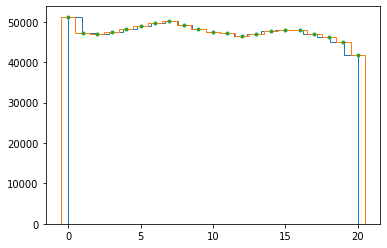

In [81]:
# plt.hist(ranks, nbins+1, histtype='step', lw=1)
plt.hist(ranks, nbins+1, histtype='step', lw=1)
plt.hist(ranks, np.arange(nbins+2)-0.5, histtype='step', lw=1)
plt.plot(*np.unique(ranks, return_counts=True), '.')

1000000
1000000


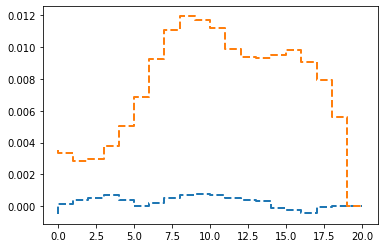

In [131]:
cdfranks = np.cumsum(np.unique(ranks, return_counts=True)[1])
print(cdfranks[-1])
cdfranks = cdfranks/cdfranks[-1]


uranks = np.random.randint(0, nbins+1, len(ranks))
cdfuranks2 = np.cumsum(np.unique(uranks, return_counts=True)[1])
cdfuranks2 = cdfuranks2/cdfuranks2[-1]

x = np.random.uniform(0, 1, int(len(ranks)))
uranks = np.random.uniform(0, 1, x.size*nbins).reshape(nbins, x.size)
uranks = (uranks < x).sum(axis=0)
cdfuranks = np.cumsum(np.unique(uranks, return_counts=True)[1])
print(cdfuranks[-1])
cdfuranks = cdfuranks/cdfuranks[-1]

plt.step(np.arange(nbins+1), cdfuranks-cdfuranks2, '--', lw=2)
plt.step(np.arange(nbins+1), cdfranks-cdfuranks2, '--', lw=2)

# for ff in [1, 10, 100] :
#     x = np.random.uniform(0, 1, int(len(ranks)*ff))
#     uranks = np.random.uniform(0, 1, x.size*nbins).reshape(nbins, x.size)
#     uranks = (uranks < x).sum(axis=0)

#     cdfuranks = np.cumsum(np.unique(uranks, return_counts=True)[1])
#     print(cdfuranks[-1])
#     cdfuranks = cdfuranks/cdfuranks[-1]

#     # plt.step(np.arange(nbins+1), cdfranks)
#     # plt.step(np.arange(nbins+1), cdfuranks)
#     plt.step(np.arange(nbins+1), cdfranks-cdfuranks)


In [120]:
cdfuranks2

array([0.047565, 0.095692, 0.143461, 0.191116, 0.238732, 0.286613,
       0.334089, 0.381587, 0.429179, 0.476728, 0.524043, 0.571384,
       0.618862, 0.666333, 0.714133, 0.761643, 0.809268, 0.856822,
       0.9043  , 0.951878, 1.      ])

In [130]:
%%timeit 
uranks = np.random.uniform(0, 1, x.size*nbins).reshape(nbins, x.size)
uranks = (uranks < x).sum(axis=0)
cdfuranks = np.cumsum(np.unique(uranks, return_counts=True)[1])


186 ms ± 2.75 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [129]:
%%timeit 


33 ms ± 748 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


1000000
1000000


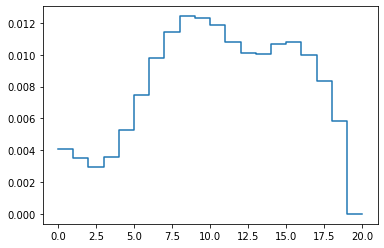

In [110]:
cdfranks = np.cumsum(np.unique(ranks, return_counts=True)[1])
print(cdfranks[-1])
cdfranks = cdfranks/cdfranks[-1]
cdfuranks = np.cumsum(np.unique(uranks, return_counts=True)[1])
print(cdfuranks[-1])
cdfuranks = cdfuranks/cdfuranks[-1]

# plt.step(np.arange(nbins+1), cdfranks)
# plt.step(np.arange(nbins+1), cdfuranks)
plt.step(np.arange(nbins+1), cdfranks-cdfuranks)


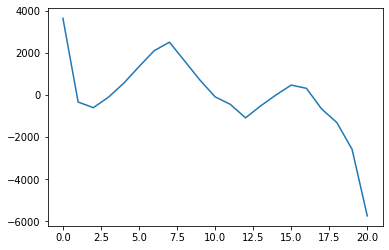

In [96]:
# plt.plot(np.unique(uranks, return_counts=True)[1])
# plt.plot(np.unique(ranks, return_counts=True)[1] - ranks.size/(nbins+1))

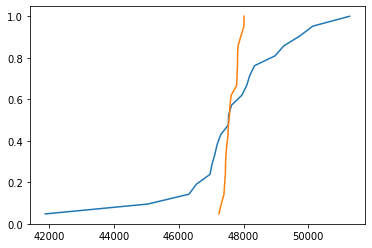

In [84]:
x = np.unique(ranks, return_counts=True)[1] #ranks.copy()
xx = np.linspace(1/x.size, 1, x.size)
xsort = np.sort(x)
plt.plot(xsort, xx)

x = np.unique(uranks, return_counts=True)[1]
xx = np.linspace(1/x.size, 1, x.size)
xsort2 = np.sort(x)
plt.plot(xsort2, xx)
plt.show()







'step 1.000//2-2'
'step 1.000//2-6'
'step 0.500//2-4'
'step 0.200//2-2'
'step 0.200//2-5'
'step 0.100//2-3'


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


'step 0.100//2-5'
'step 0.100//2-6'
'step 1.000//5-2'
'step 1.000//5-3'
'step 1.000//5-4'
'step 1.000//5-5'
'step 1.000//5-6'
'step 0.500//5-2'
'step 0.500//5-3'
'step 0.500//5-4'
'step 0.500//5-5'
'step 0.500//5-6'
'step 0.200//5-2'
'step 0.200//5-3'
'step 0.200//5-4'
'step 0.200//5-5'
'step 0.200//5-6'
'step 0.100//5-2'
'step 0.100//5-3'
'step 0.100//5-4'
'step 0.100//5-5'
'step 0.100//5-6'


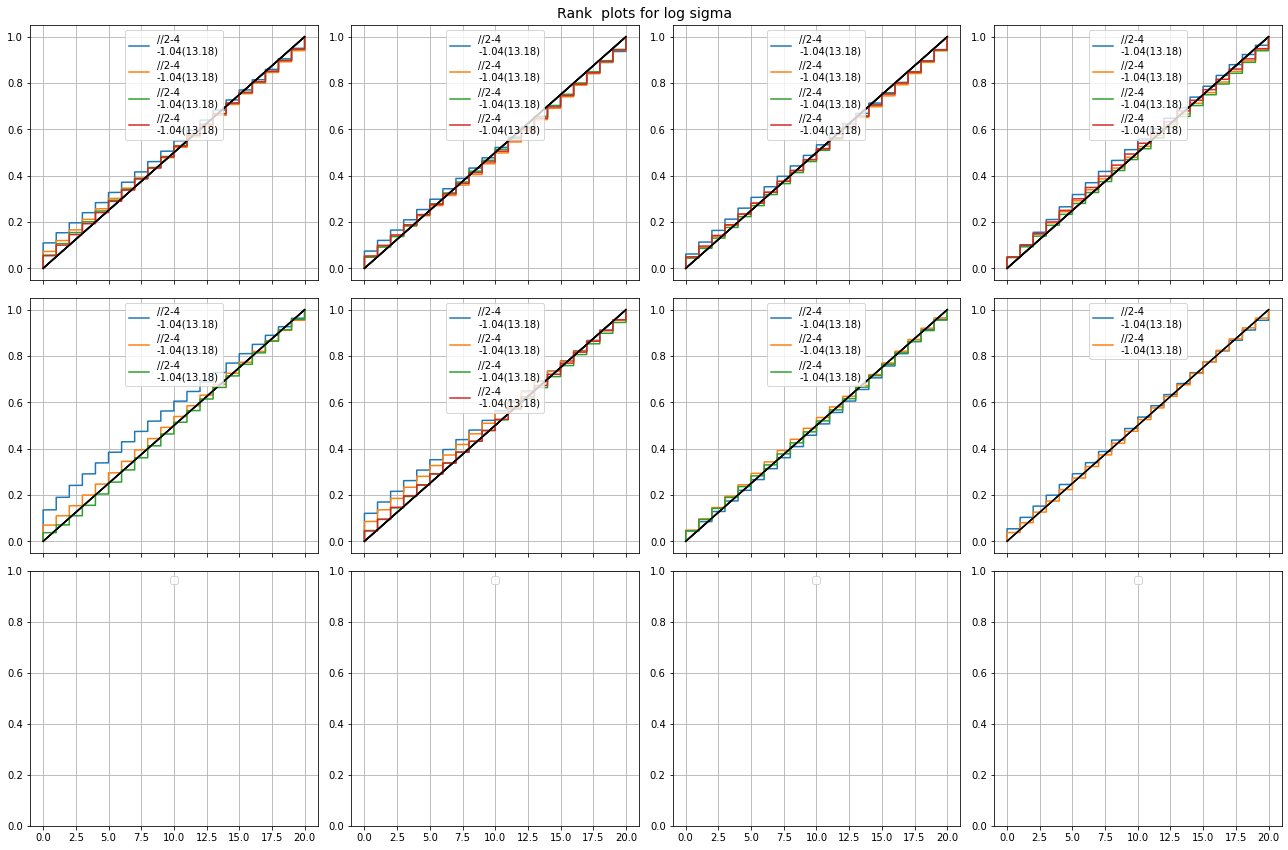

In [512]:
nbins = 20
q0 = np.quantile(np.random.binomial(sigmarep.size, 1/(nbins+1), 100000), 0.005)
q1 = np.quantile(np.random.binomial(sigmarep.size, 1/(nbins+1), 100000), 0.995)
ii = 0


fig, axar = plt.subplots(3, 4, figsize=(18, 12 ), sharex=True)

for iff, fidkey in enumerate (['step 0.200', 'step 0.100', 'step 0.050', 'step 0.010']): 

    ax = axar[0, iff]
    keys = [fidkey] + [fidkey + '//%s'%i for i in [2, 5, 10]]

    for ik, kk in enumerate(keys):
        try: test = samples0[kk]
        except Exception as e: 
            print(e)
            continue
        rcc, tcc = get_rcc(test[..., ii])
#         hmcsamples = (np.concatenate([test[::, i, ii] for i in range(test.shape[1])]))
#         hmcsamples = (np.concatenate([test[::int(tcc.mean()), i, ii] for i in range(test.shape[1])]))
        hmcsamples = (np.concatenate([test[::int(tcc[i]), i, ii] for i in range(test.shape[1])]))

        batch = hmcsamples[np.random.randint(0, hmcsamples.size, nbins*sigmarep.size).reshape(nbins, sigmarep.size)] 
        if ii == 0: ranks = (batch < sigmarep).sum(axis=0)
        else: ranks = (batch < alpharep).sum(axis=0)

        x = ranks.copy()
        xx = np.linspace(1/x.size, 1, x.size)
        xsort = np.sort(x)
        ax.plot(xsort, xx, label=lbl)

        x = np.random.uniform(0, ranks.max(), len(ranks))
        xx = np.linspace(1/x.size, 1, x.size)
        xsort = np.sort(x)
        ax.plot(xsort, xx, 'k')




for iff, fidkey in enumerate (['step 1.000//2', 'step 0.500//2', 'step 0.200//2', 'step 0.100//2', 
                              'step 1.000//5', 'step 0.500//5', 'step 0.200//5', 'step 0.100//5']): 

    ax = axar[1:].flatten()[iff]
    keys = [fidkey + '-%d'%i for i in [2, 3, 4, 5, 6]]
    
    for ik, kk in enumerate(keys):
        try: test = samples[kk]
        except Exception as e:
            print(e)
            continue
        rcc, tcc = get_rcc(test[..., ii])
#         hmcsamples = (np.concatenate([test[::, i, ii] for i in range(test.shape[1])]))
#         hmcsamples = (np.concatenate([test[::int(tcc.mean()), i, ii] for i in range(test.shape[1])]))
        hmcsamples = (np.concatenate([test[::int(tcc[i]), i, ii] for i in range(test.shape[1])]))

        batch = hmcsamples[np.random.randint(0, hmcsamples.size, nbins*sigmarep.size).reshape(nbins, sigmarep.size)] 
        if ii == 0: ranks = (batch < sigmarep).sum(axis=0)
        else: ranks = (batch < alpharep).sum(axis=0)

        x = ranks.copy()
        xx = np.linspace(1/x.size, 1, x.size)
        xsort = np.sort(x)
        ax.plot(xsort, xx, label=lbl)

        x = np.random.uniform(0, ranks.max(), len(ranks))
        xx = np.linspace(1/x.size, 1, x.size)
        xsort = np.sort(x)
        ax.plot(xsort, xx, 'k')


        
for axis in axar.flatten():
    axis.grid()
    axis.legend(loc='upper center')
#     axis.fill_between(np.arange(0, nbins), q0, q1, color='k', alpha=0.5)


plt.suptitle('Rank  plots for log sigma', fontsize=14)
plt.tight_layout()